In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
df = pd.read_csv("Data-GP1-1(updated).csv")
df

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Day,Date,Month,Year,Stormy,Mixed,p,q,Rainy,Cold,Wind,Date Error
0,1,0,0,0,0,0,0,Mon,2,12,91,1,0,-0.430783,8.994421,1,0,2.995732,False
1,0,1,0,0,0,0,0,Tue,3,12,91,1,0,0.000000,7.707063,0,0,2.995732,False
2,0,0,1,0,0,0,0,Wed,4,12,91,0,1,0.072321,8.350194,1,1,2.813411,False
3,0,0,0,1,0,0,0,Thu,5,12,91,1,0,0.247139,8.656955,0,1,3.036554,False
4,0,0,0,0,1,0,0,Fri,6,12,91,1,0,0.664327,7.844241,0,1,3.036554,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1,0,0,0,0,0,0,Mon,4,5,92,0,0,-0.798508,8.610683,0,0,2.862201,False
107,0,1,0,0,0,0,0,Tue,5,5,92,0,1,-0.087011,7.162397,0,0,2.908721,False
108,0,0,1,0,0,0,0,Wed,6,5,92,0,1,0.184922,7.362010,0,0,2.862201,False
109,0,0,0,1,0,0,0,Thu,7,5,92,0,1,0.223143,8.764053,0,0,2.813411,False


21


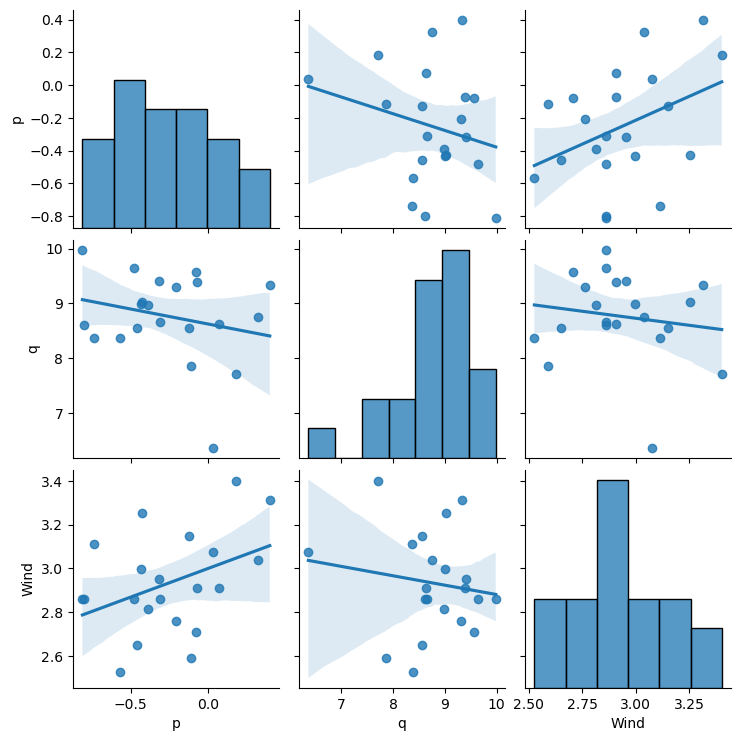

In [23]:
print(f"{(df['Mon'] == 1).sum()}")

sns.pairplot(df[df["Mon"] == 1][["p","q", "Wind"]], kind="reg")

23


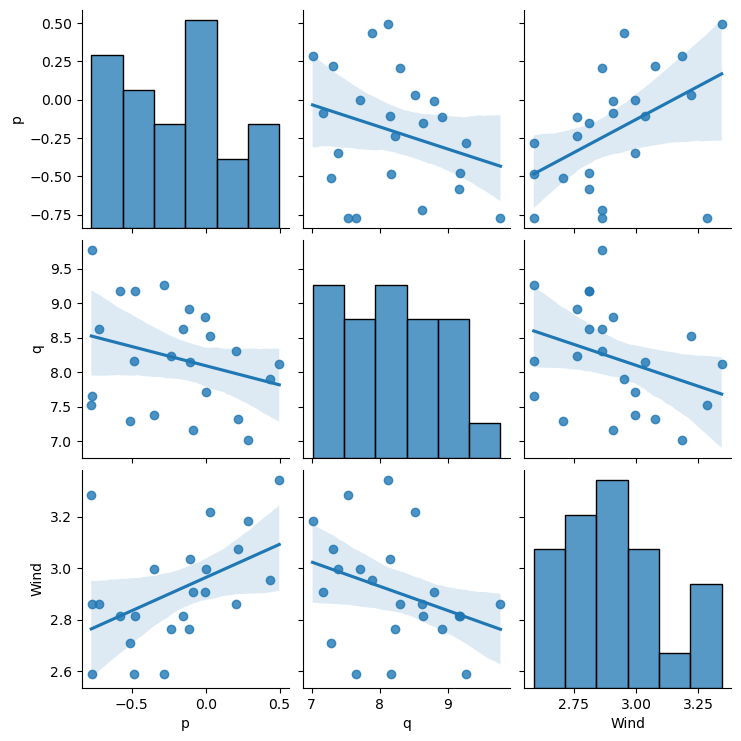

In [24]:
print(f"{(df['Tue'] == 1).sum()}")

sns.pairplot(df[df["Tue"] == 1][["p","q", "Wind"]], kind="reg")

21


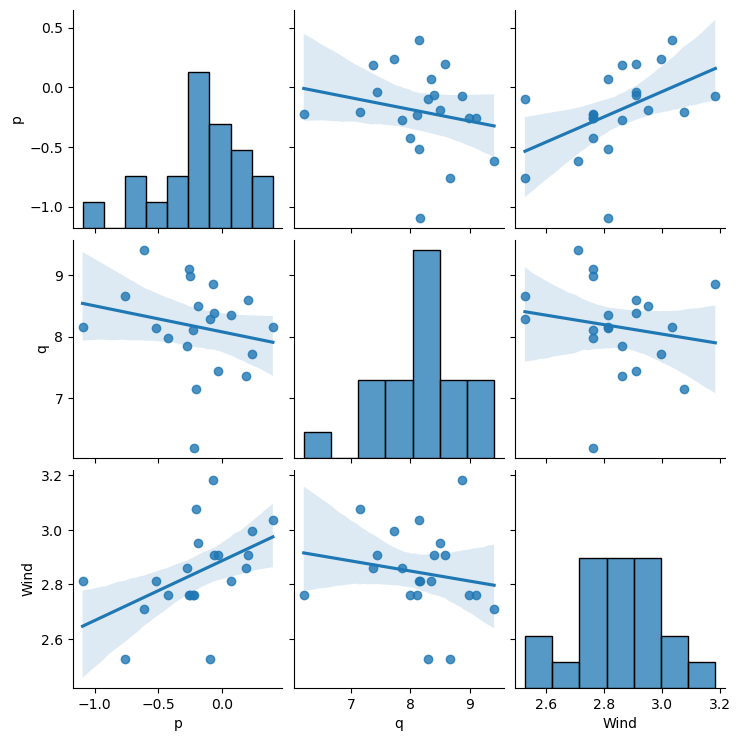

In [25]:
print(f"{(df['Wed'] == 1).sum()}")

sns.pairplot(df[df["Wed"] == 1][["p","q", "Wind"]], kind="reg")

23


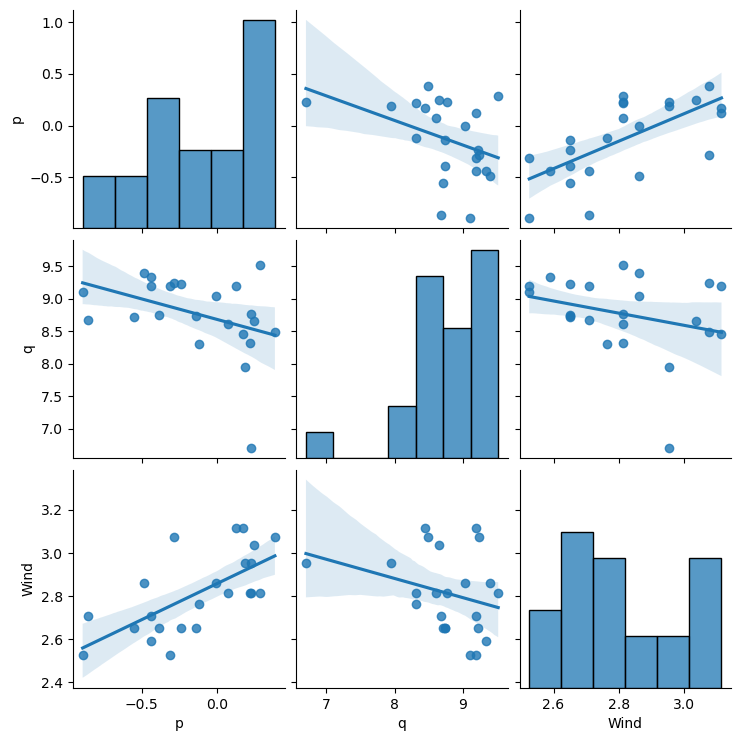

In [26]:
print(f"{(df['Thu'] == 1).sum()}")

sns.pairplot(df[df["Thu"] == 1][["p","q", "Wind"]], kind="reg")

23


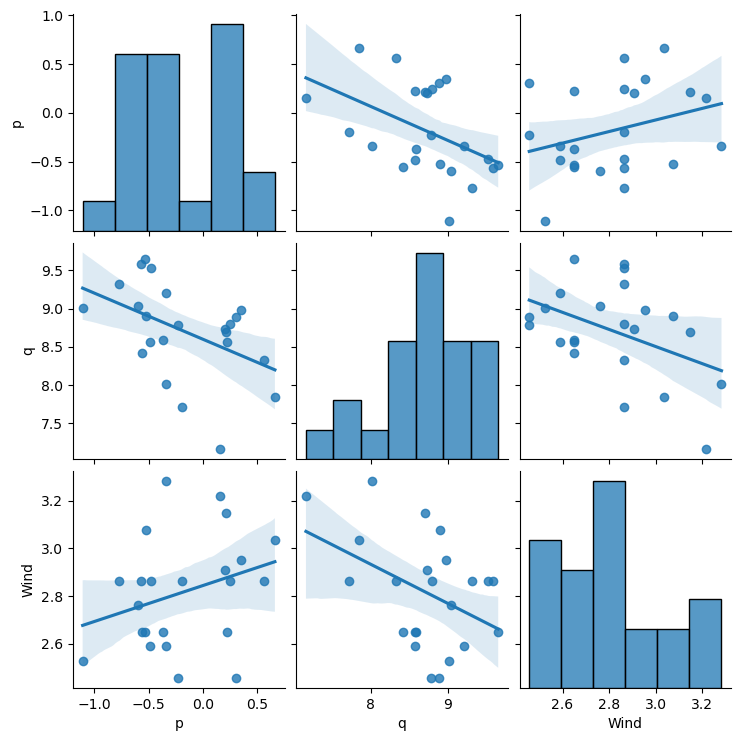

In [27]:
print(f"{(df['Fri'] == 1).sum()}")

sns.pairplot(df[df["Fri"] == 1][["p","q", "Wind"]], kind="reg")

In [28]:
print(f"{(df['Sat'] == 1).sum()}")
print(f"{(df['Sun'] == 1).sum()}")

0
0


21


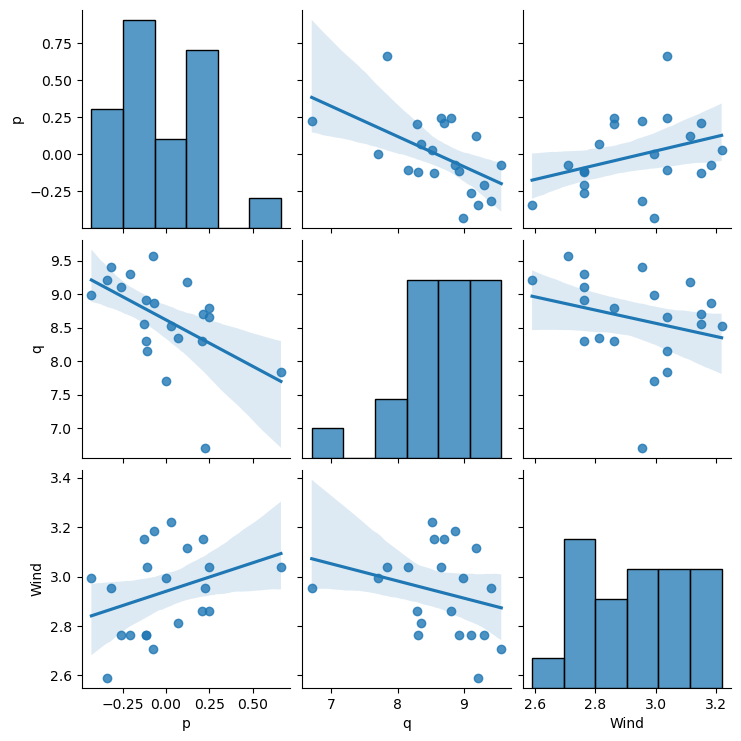

In [29]:
print(f"{(df['Year'] == 91).sum()}")

sns.pairplot(df[df["Year"] == 91][["p","q", "Wind"]], kind="reg")

90


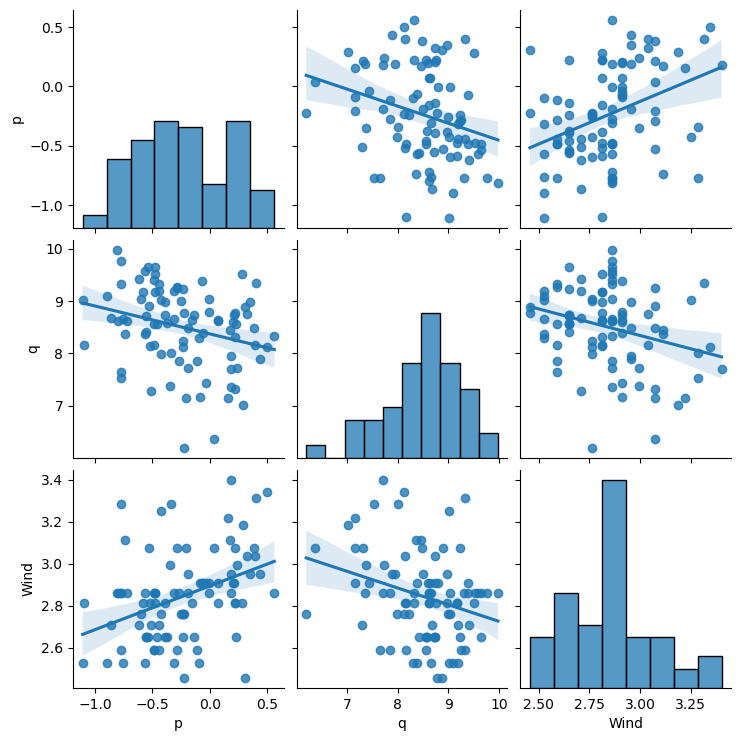

In [30]:
print(f"{(df['Year'] == 92).sum()}")

sns.pairplot(df[df["Year"] == 92][["p","q", "Wind"]], kind="reg")